In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("dihydrofolato.csv")

In [3]:
data.head()

,Unnamed: 0,entry,entry_name,status,protein_names,gene_names,organism,length,taxonomic,EC,sequence
0,0,Q86XF0,DYR2_HUMAN,reviewed,"Dihydrofolate reductase 2, mitochondrial (Dihy...",DHFR2 DHFRL1 DHFRP4,Homo sapiens (Human),187,"cellular organisms, Eukaryota, Opisthokonta, M...",1.5.1.3,MFLLLNCIVAVSQNMGIGKNGDLPRPPLRNEFRYFQRMTTTSSVEG...
1,4,P00374,DYR_HUMAN,reviewed,Dihydrofolate reductase (EC 1.5.1.3),DHFR,Homo sapiens (Human),187,"cellular organisms, Eukaryota, Opisthokonta, M...",1.5.1.3,MVGSLNCIVAVSQNMGIGKNGDLPWPPLRNEFRYFQRMTTTSSVEG...
2,5,P0ABQ4,DYR_ECOLI,reviewed,Dihydrofolate reductase (EC 1.5.1.3),folA tmrA b0048 JW0047,Escherichia coli (strain K12),159,"cellular organisms, Bacteria, Proteobacteria, ...",1.5.1.3,MISLIAALAVDRVIGMENAMPWNLPADLAWFKRNTLNKPVIMGRHT...
3,6,P00375,DYR_MOUSE,reviewed,Dihydrofolate reductase (EC 1.5.1.3),Dhfr,Mus musculus (Mouse),187,"cellular organisms, Eukaryota, Opisthokonta, M...",1.5.1.3,MVRPLNCIVAVSQNMGIGKNGDLPWPPLRNEFKYFQRMTTTSSVEG...
4,8,Q920D2,DYR_RAT,reviewed,Dihydrofolate reductase (EC 1.5.1.3),Dhfr,Rattus norvegicus (Rat),187,"cellular organisms, Eukaryota, Opisthokonta, M...",1.5.1.3,MVRPLNCIVAVSQNMGIGKNGDLPWPLLRNEFKYFQRMTTTSSVEG...


In [4]:
data.shape

(34637, 11)

In [5]:
aminoacids = ["A", "R","N","D","C","Q","E","G","H","I","L","K","M","F","P","S","T","W","Y","V"]

In [6]:
set_aa = set(aminoacids)
data_pro_canonical = data[data["sequence"].apply(lambda x: set(x).issubset(set_aa))]

In [7]:
data_pro_canonical.shape

(34344, 11)

In [8]:
data_pro_canonical = data_pro_canonical[data_pro_canonical.length <= 256]

In [9]:
data_pro_canonical.shape

(34344, 11)

In [10]:
from tensorflow import keras

In [11]:
def encode_padding(list_sequences, length):
    aminoacids_s = ["A", "R","N","D","C","Q","E","G","H","I","L","K","M","F","P","S","T","W","Y","V","$"]
    aminoacids_dict = {aminoacids_s[x]:x for x in range(len(aminoacids_s))}
    sequences_padded = []
    for sequence in list_sequences:
        if len(sequence) < length:
            sequence_padded = sequence + "$" * (length-len(sequence))
            sequences_padded.append(sequence_padded)
        else:
            sequences_padded.append(sequence)
    result = []
    
    for sequence in sequences_padded:
        sequence_encoded = []
        for char in sequence:
            sequence_encoded.append(aminoacids_dict[char])
        result.append(sequence_encoded)
    return(result)
sequences = list(data_pro_canonical.sequence)
seqs = encode_padding(sequences, length = 256)    

In [12]:
X_train = keras.utils.to_categorical(seqs, num_classes = len(aminoacids)+1)


In [13]:
import numpy as np
def padd_reshape(output_shape, arrays):
    
    result = []
                      
    for arrai in range(arrays.shape[0]):
        padded_array = np.zeros((output_shape[0], output_shape[1]))
        shape = np.shape(arrays[arrai])
        padded_array[:shape[0],:shape[1]] = arrays[arrai]
        result.append(padded_array)
    return(np.array(result))

X_train = padd_reshape([256, 28], X_train)

In [14]:
X_train = np.expand_dims(X_train, -1)
X_train.shape

(34344, 256, 28, 1)

In [15]:
import matplotlib.pyplot as plt

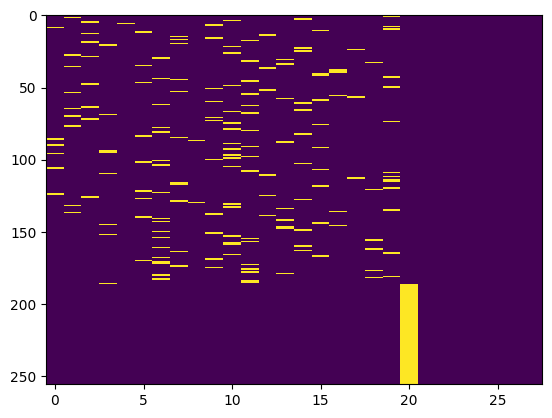

In [17]:
plt.imshow(X_train[4],interpolation='nearest', aspect='auto')
plt.show()

In [18]:
data_pro_canonical["dominio"] = data_pro_canonical.taxonomic.apply(lambda row: row.split(",")[1])

In [19]:
data_pro_canonical.dominio.value_counts()

 Bacteria                          30037
 Eukaryota                          2321
 Archaea                             890
 Duplodnaviria                       768
 unclassified sequences              285
 unclassified viruses                 22
 Varidnaviria                         16
 unclassified bacterial viruses        1
 environmental samples                 1
 other sequences                       1
 Nudiviridae                           1
 Hytrosaviridae                        1
Name: dominio, dtype: int64

In [20]:
Y_train = list(data_pro_canonical.dominio)

In [20]:
from tensorflow.keras import mixed_precision

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 3080 Ti, compute capability 8.6


In [22]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides,
                padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=1,
                padding="same", use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides == [2,1]:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides,
                    padding="same", use_bias=False),
                keras.layers.BatchNormalization()]
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)


        
    

encoder3 = keras.models.Sequential()
encoder3.add(keras.layers.Conv2D(64, 1, strides=1, input_shape=[256, 28,1],padding="same", use_bias=False))
encoder3.add(keras.layers.BatchNormalization())
encoder3.add(keras.layers.Activation("relu"))
#for filters in [512] * 3 + [256] * 3 + [128] * 4 + [64] * 3 + [32] * 6:
prev_filters = 64
for filters in  [64] * 1 + [128] * 1 + [256] * 1 + [512] * 1:
    strides = [1,1] if filters == prev_filters else [2,1]
    encoder3.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
encoder3.add(keras.layers.Conv2D(512, 3, strides=2,padding="same", use_bias=False, activation = "relu"))
encoder3.add(keras.layers.Conv2D(128, 3, strides=2,padding="same", use_bias=False, activation = "relu"))
encoder3.add(keras.layers.Flatten())
encoder3.add(keras.layers.BatchNormalization())
encoder3.add(keras.layers.Dense(100, activation="relu"))


In [23]:
encoder3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 256, 28, 64)       64        
                                                                 
 batch_normalization_37 (Bat  (None, 256, 28, 64)      256       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 256, 28, 64)       0         
                                                                 
 residual_unit_16 (ResidualU  (None, 256, 28, 64)      74240     
 nit)                                                            
                                                                 
 residual_unit_17 (ResidualU  (None, 128, 28, 128)     230912    
 nit)                                                            
                                                      

In [24]:
class ResidualUnit_t(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2DTranspose(filters, 3, strides=strides,
                padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            
            keras.layers.Conv2DTranspose(filters, 3, strides=1,
                padding="same", use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides == [2,1]:
            self.skip_layers = [
                keras.layers.Conv2DTranspose(filters, 1, strides=strides,
                    padding="same", use_bias=False),
                keras.layers.BatchNormalization()]
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)
decoder3 = keras.Sequential()
decoder3.add(keras.layers.Dense(8*7*128, use_bias = False, input_shape=(100,)))
decoder3.add(keras.layers.BatchNormalization())
decoder3.add(keras.layers.LeakyReLU())
decoder3.add(keras.layers.Reshape((8, 7, 128)))
decoder3.add(keras.layers.Conv2DTranspose(128, 3, strides=2,padding="same", use_bias=False, activation="relu"))
decoder3.add(keras.layers.Conv2DTranspose(512, 3, strides=2,padding="same", use_bias=False, activation="relu"))
prev_filters = 512
#for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
for filters in [512] * 1 + [256] * 1 + [128] * 1 + [64] * 1 :
    strides = [1,1] if filters == prev_filters else [2,1]
    decoder3.add(ResidualUnit_t(filters, strides=strides))
    prev_filters = filters




decoder3.add(keras.layers.Conv2DTranspose(1, (3, 3), strides=1, padding='same', use_bias=False, activation='relu'))
decoder3.add(keras.layers.BatchNormalization())


In [25]:
decoder3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 7168)              716800    
                                                                 
 batch_normalization_50 (Bat  (None, 7168)             28672     
 chNormalization)                                                
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 7168)              0         
                                                                 
 reshape (Reshape)           (None, 8, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 14, 128)      147456    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 28, 512)     

In [26]:
prote_autoencoder = keras.models.Sequential([encoder3, decoder3])

In [27]:
prote_autoencoder.summary()
prote_autoencoder.dtype

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 100)               8596900   
                                                                 
 sequential_2 (Sequential)   (None, 256, 28, 1)        8705860   
                                                                 
Total params: 17,302,760
Trainable params: 17,263,590
Non-trainable params: 39,170
_________________________________________________________________


'float32'

In [28]:
prote_autoencoder.compile(loss="binary_crossentropy",optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=["accuracy"])

In [30]:
history=prote_autoencoder.fit(X_train, X_train, epochs=10, validation_split=0.2)

Epoch 1/10
859/859 [==============================] - 126s 147ms/step - loss: 0.3632 - accuracy: 0.9573 - val_loss: 0.3030 - val_accuracy: 0.9618
Epoch 2/10
859/859 [==============================] - 124s 145ms/step - loss: 0.3097 - accuracy: 0.9605 - val_loss: 0.2646 - val_accuracy: 0.9625
Epoch 3/10
859/859 [==============================] - 124s 145ms/step - loss: 0.2862 - accuracy: 0.9615 - val_loss: 0.2563 - val_accuracy: 0.9630
Epoch 4/10
859/859 [==============================] - 124s 144ms/step - loss: 0.2205 - accuracy: 0.9617 - val_loss: 0.1507 - val_accuracy: 0.9645
Epoch 5/10
859/859 [==============================] - 124s 145ms/step - loss: 0.1631 - accuracy: 0.9643 - val_loss: 0.1430 - val_accuracy: 0.9652
Epoch 6/10
859/859 [==============================] - 125s 146ms/step - loss: 0.1369 - accuracy: 0.9715 - val_loss: 0.1175 - val_accuracy: 0.9739
Epoch 7/10
859/859 [==============================] - 124s 144ms/step - loss: 0.1294 - accuracy: 0.9728 - val_loss: 0.1239 -

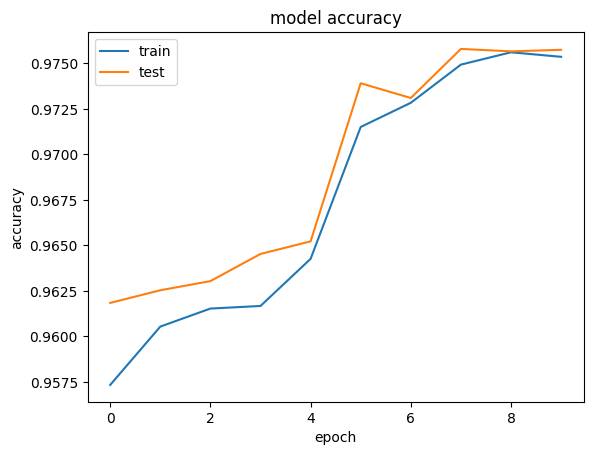

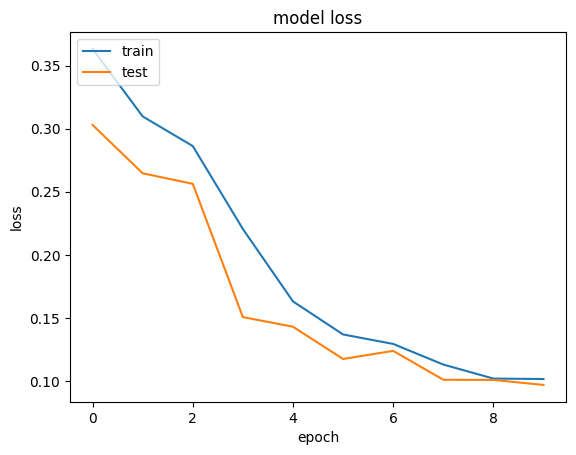

In [31]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [32]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

results = encoder3.predict(X_train)

datas = np.array(Y_train)
data_cat = le.fit_transform(datas)


In [33]:
labels = dict(zip(le.transform(le.classes_),le.classes_ ))

In [35]:
tsne = TSNE(perplexity=100)
encoded_2d = tsne.fit_transform(results )

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [36]:
np.save("espacio_latente_autoencoderdf.npy", results)

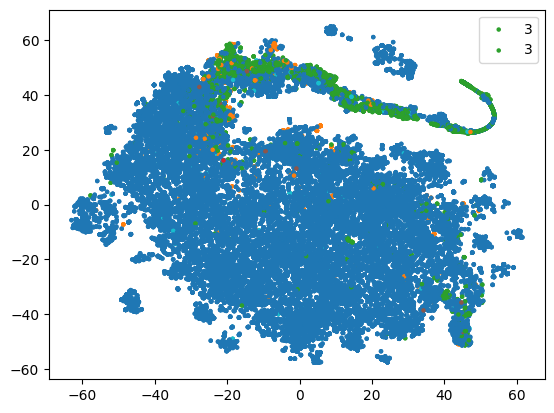

In [38]:
plt.scatter(encoded_2d[:, 0], encoded_2d[:, 1] ,c = data_cat, s=5, cmap="tab10")
plt.legend(data_cat)
plt.show()

In [39]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
encoded_2dd = pca.fit_transform(results)


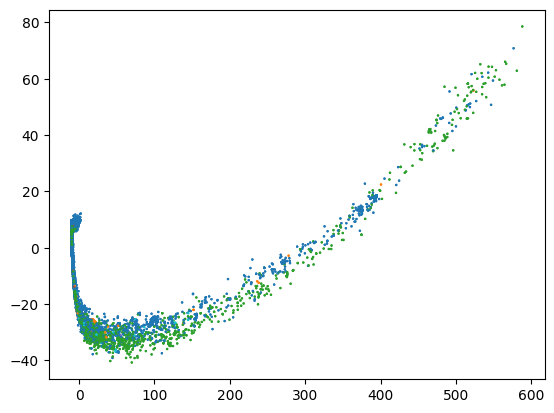

In [41]:

plt.scatter(encoded_2dd[:, 0], encoded_2dd[:, 1] ,c = data_cat, s=0.5, cmap="tab10", label=labels)
plt.show()

In [42]:
data_pro_canonical.dominio.value_counts()

 Bacteria                          30037
 Eukaryota                          2321
 Archaea                             890
 Duplodnaviria                       768
 unclassified sequences              285
 unclassified viruses                 22
 Varidnaviria                         16
 unclassified bacterial viruses        1
 environmental samples                 1
 other sequences                       1
 Nudiviridae                           1
 Hytrosaviridae                        1
Name: dominio, dtype: int64